In [357]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import pickle
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [358]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [359]:
df1 = pd.read_csv('/content/drive/MyDrive/Capstone_Project/Datasets/archive/stations.csv', encoding = 'latin-1')
df2 = pd.read_csv('/content/drive/MyDrive/Capstone_Project/Datasets/archive/city_day.csv', encoding = 'latin-1')

In [360]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ï»¿StationId  230 non-null    object
 1   StationName   230 non-null    object
 2   City          230 non-null    object
 3   State         230 non-null    object
 4   Status        133 non-null    object
dtypes: object(5)
memory usage: 9.1+ KB


In [361]:
df1 = df1.rename(columns={'ï»¿StationId': 'StationId'})

In [362]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   StationId    230 non-null    object
 1   StationName  230 non-null    object
 2   City         230 non-null    object
 3   State        230 non-null    object
 4   Status       133 non-null    object
dtypes: object(5)
memory usage: 9.1+ KB


In [363]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   N2O         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


In [364]:
merged_df = pd.merge(df1, df2, on='City')

In [365]:
merged_df.drop_duplicates(inplace=True)

In [366]:
merged_df['City'] = merged_df['City'].apply(lambda x: x.split(',')[0].split(' ')[0])

In [367]:
merged_df.head()

,StationId,StationName,City,State,Status,Date,PM2.5,PM10,NO,N2O,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active,24/11/17,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,NaN,NaN
1,AP001,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active,25/11/17,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2,AP001,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active,26/11/17,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate
3,AP001,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active,27/11/17,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate
4,AP001,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active,28/11/17,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate


In [368]:
merge_df = merged_df.drop(['PM2.5','PM10','NOx','NH3','SO2','O3','Benzene','Toluene','Xylene','AQI','AQI_Bucket'],axis=1)

In [369]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186670 entries, 0 to 186669
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   StationId    186670 non-null  object 
 1   StationName  186670 non-null  object 
 2   City         186670 non-null  object 
 3   State        186670 non-null  object 
 4   Status       186346 non-null  object 
 5   Date         186670 non-null  object 
 6   NO           169790 non-null  float64
 7   N2O          169699 non-null  float64
 8   CO           182963 non-null  float64
dtypes: float64(3), object(6)
memory usage: 14.2+ MB


In [370]:
# Assuming your DataFrame is named df
merge_df['tot_emission'] = merge_df['NO'].fillna(0) + merge_df['N2O'].fillna(0) + merge_df['CO'].fillna(0)


In [371]:
merge_df.head()

,StationId,StationName,City,State,Status,Date,NO,N2O,CO,tot_emission
0,AP001,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active,24/11/17,1.75,20.65,0.10,22.50
1,AP001,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active,25/11/17,1.44,20.50,0.12,22.06
2,AP001,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active,26/11/17,1.26,26.00,0.14,27.40
3,AP001,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active,27/11/17,6.60,30.85,0.11,37.56
4,AP001,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active,28/11/17,2.56,28.07,0.09,30.72


In [372]:
import pandas as pd

# Assuming your DataFrame is named df
# If not, replace df with the actual name of your DataFrame

# Convert 'Date' column to datetime format
merge_df['Date'] = pd.to_datetime(merge_df['Date'], format='%d/%m/%y')

# Group by 'State' and 'Date', then aggregate the sum of 'N2O', 'CO', and 'NO'
total_emissions = merge_df.groupby(['State', 'Date'])[['N2O', 'CO', 'NO']].sum().reset_index()

# Add a new column 'Total_Emission' which is the sum of 'N2O', 'CO', and 'NO'
total_emissions['Total_Emission'] = total_emissions['N2O'] + total_emissions['CO'] + total_emissions['NO']

# Print the result
print(total_emissions)


                State       Date     N2O    CO     NO  Total_Emission
0      Andhra Pradesh 2016-07-01   56.96  1.00  16.75           74.71
1      Andhra Pradesh 2016-07-02    0.00  0.00   0.00            0.00
2      Andhra Pradesh 2016-07-03    0.00  0.00   0.00            0.00
3      Andhra Pradesh 2016-07-04    0.00  0.00   0.00            0.00
4      Andhra Pradesh 2016-07-05   25.08  0.66   7.32           33.06
...               ...        ...     ...   ...    ...             ...
26940     West Bengal 2020-06-27   64.75  2.45  36.68          103.88
26941     West Bengal 2020-06-28   88.41  2.66  41.58          132.65
26942     West Bengal 2020-06-29  111.86  3.15  37.94          152.95
26943     West Bengal 2020-06-30   86.03  2.59  43.75          132.37
26944     West Bengal 2020-07-01   70.07  2.10  43.75          115.92

[26945 rows x 6 columns]


In [373]:
# Convert the state names in your emissions data frame to uppercase
total_emissions['State'] = total_emissions['State'].str.upper()

In [374]:
print(total_emissions)

                State       Date     N2O    CO     NO  Total_Emission
0      ANDHRA PRADESH 2016-07-01   56.96  1.00  16.75           74.71
1      ANDHRA PRADESH 2016-07-02    0.00  0.00   0.00            0.00
2      ANDHRA PRADESH 2016-07-03    0.00  0.00   0.00            0.00
3      ANDHRA PRADESH 2016-07-04    0.00  0.00   0.00            0.00
4      ANDHRA PRADESH 2016-07-05   25.08  0.66   7.32           33.06
...               ...        ...     ...   ...    ...             ...
26940     WEST BENGAL 2020-06-27   64.75  2.45  36.68          103.88
26941     WEST BENGAL 2020-06-28   88.41  2.66  41.58          132.65
26942     WEST BENGAL 2020-06-29  111.86  3.15  37.94          152.95
26943     WEST BENGAL 2020-06-30   86.03  2.59  43.75          132.37
26944     WEST BENGAL 2020-07-01   70.07  2.10  43.75          115.92

[26945 rows x 6 columns]


In [375]:
import geopandas as gpd

# Define the file path without the file extension
file_path = '/content/drive/MyDrive/Capstone_Project/Datasets/india_st'

# Load the shapefile using geopandas
india = gpd.read_file(f'/content/drive/MyDrive/Capstone_Project/Datasets/india_st.dbf')

In [376]:
india.head()

,STATE,geometry
0,ANDAMAN AND NICOBAR ISLANDS,"MULTIPOLYGON (((94.08923 6.73365, 93.97717 6.9..."
1,ANDHRA PRADESH,"POLYGON ((82.00063 17.95354, 82.11718 18.02457..."
2,ARUNACHAL PRADESH,"POLYGON ((95.61476 27.34745, 95.69234 27.33888..."
3,ASSAM,"POLYGON ((92.82207 25.57781, 92.69672 25.61368..."
4,BIHAR,"POLYGON ((84.16946 26.28322, 83.91399 26.38523..."


<Axes: >

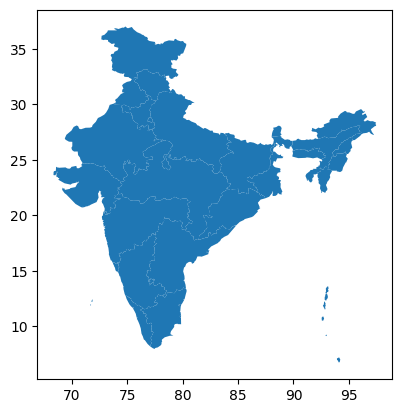

In [377]:
india.plot()

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


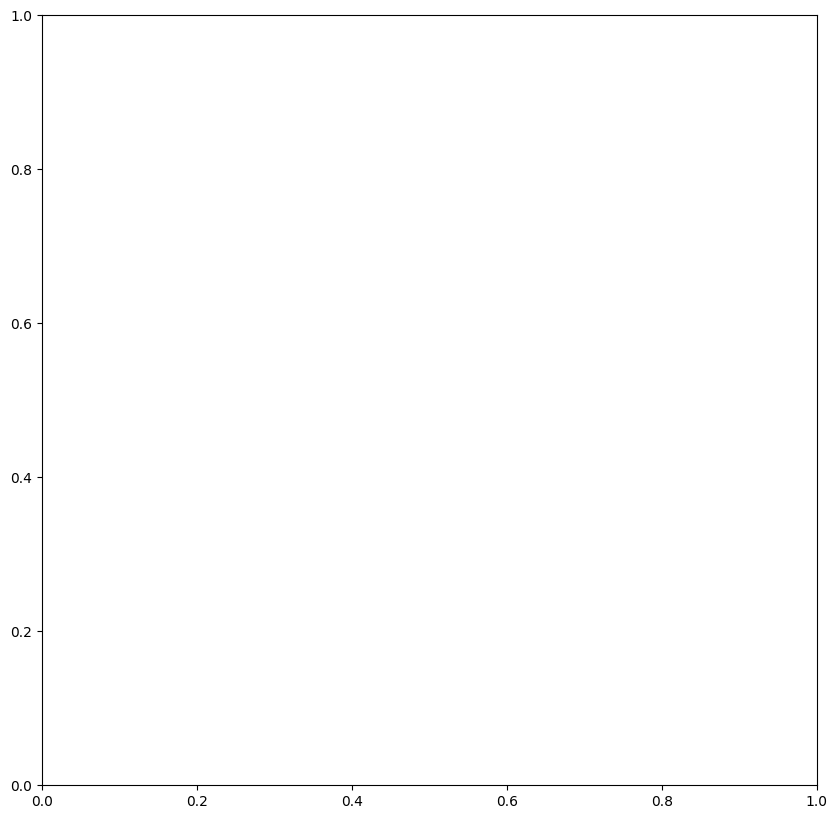

In [378]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation

# Merge the total emissions data with the shapefile
merged_data = india.merge(total_emissions, left_on='STATE', right_on='State')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Define a function to update the plot for each date
def update(frame):
    plt.cla()  # Clear the current axis
    ax.axis('off')  # Turn off the axis labels

    # Plot the base map of India
    india.boundary.plot(ax=ax, linewidth=0.5, color='black')

    # Filter data for the current date
    data = merged_data[merged_data['Date'] == total_emissions['Date'].unique()[frame]]

    # Plot the total emissions as a heatmap
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    data.plot(column='Total_Emission', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax=cax)

    # Add a title
    ax.set_title('Total Emissions on {}'.format(data['Date'].iloc[0].strftime('%Y-%m-%d')), fontdict={'fontsize': '15', 'fontweight' : '3'})

# Create an animation
ani = FuncAnimation(fig, update, frames=len(total_emissions['Date'].unique()), repeat=False, interval=1000)

# Show the animation
plt.show()